# Final Project Submission

Please fill out:
* Student name: 
* Student pace: self paced / part time / full time
* Scheduled project review date/time: 
* Instructor name: 
* Blog post URL:


# House Price Forecasting with Regression Modeling

## Project Overview

The project focuses on the creation of a machine learning project for house price forecasting for all stakeholders involved from investors to owners to buyers.

## Background Information

There are comparisons that have already been done on the difference in house prices in houses having waterfronts, and those without. Research shows that the closer a house is to a waterfront, the more expensive it is. However, it is notable that the different houses with the same waterfront have different prices. There are things shared by different houses on the same front such as geographical location, available amenities and a shared waterfront or ocean. There are also differences in the houses based on the overall size of the house, the proximity to neighbors and the different provisions in the houses among others. There are situations where some houses share certain attributes such as the same number of floors, number of bathrooms and an almost similar size and design in the house, yet the houses have a different pricing, and sometimes it is difficult to understand the difference in the pricing. There are no studies and experiments, though, showing how the different factors the house prices.

## Challenges

1. Unavailability of Metrics: We lack access to the metrics used for grading houses, making it difficult to assess property values accurately.

2. External Factors: The housing market is susceptible to external factors such as changing policies and economic fluctuations, impacting price trends.

3. Insufficient Data: Limited data hampers the development of a recommendation system. We need more data on local amenities, security, and how they vary across geographical regions.

4. Historical Data: Tracking historical house price changes and their geographical variations is currently impossible


## Solutions

* Explore feature engineering to create new features that can help improve our model.

* To combine multiple models into an ensemble to capture patterns in the data.

## Problem Statement

Sometimes investors know how certain metrics and attributes affect house pricing, but they are not sure to what extent the metrics affect the pricing. Additionally, there are a combination of factors that affect the overall pricing of the houses. Unfortunately, the investors also cannot tell how the different combinations may affect the house pricing. They struggle to decide how much to price the houses based on the different combinations, and the random assumptions may lead to overpricing or underpricing of the units.

## Objectives

### General Objective

* To develop and implement a ML based solution that leverages data analytics and predictive models to give accurate insights and enable real estate developers to make informed decisions



### Specific Objectives

* To develop a price prediction model  
* To identify and select the most relevant features to build the model
* To provide recommendations to the stakeholders based on our model



## Data Understanding

This project uses the King County House Sales dataset. The data contains the following columns.

### Column Names and Descriptions for King County Data Set
* `id` - Unique identifier for a house
* `date` - Date house was sold
* `price` - Sale price (prediction target)
* `bedrooms` - Number of bedrooms
* `bathrooms` - Number of bathrooms
* `sqft_living` - Square footage of living space in the home
* `sqft_lot` - Square footage of the lot
* `floors` - Number of floors (levels) in house
* `waterfront` - Whether the house is on a waterfront
  * Includes Duwamish, Elliott Bay, Puget Sound, Lake Union, Ship Canal, Lake Washington, Lake Sammamish, other lake, and river/slough waterfronts
* `view` - Quality of view from house
  * Includes views of Mt. Rainier, Olympics, Cascades, Territorial, Seattle Skyline, Puget Sound, Lake Washington, Lake Sammamish, small lake / river / creek, and other
* `condition` - How good the overall condition of the house is. Related to maintenance of house.
  * See the [King County Assessor Website](https://info.kingcounty.gov/assessor/esales/Glossary.aspx?type=r) for further explanation of each condition code
* `grade` - Overall grade of the house. Related to the construction and design of the house.
  * See the [King County Assessor Website](https://info.kingcounty.gov/assessor/esales/Glossary.aspx?type=r) for further explanation of each building grade code
* `sqft_above` - Square footage of house apart from basement
* `sqft_basement` - Square footage of the basement
* `yr_built` - Year when house was built
* `yr_renovated` - Year when house was renovated
* `zipcode` - ZIP Code used by the United States Postal Service
* `lat` - Latitude coordinate
* `long` - Longitude coordinate
* `sqft_living15` - The square footage of interior housing living space for the nearest 15 neighbors
* `sqft_lot15` - The square footage of the land lots of the nearest 15 neighbors


In [42]:
# Import necessary libraries for data analysis and visualization

# Pandas is used for data manipulation and analysis
import pandas as pd

# NumPy is used for numerical computations and data manipulation
import numpy as np

# Seaborn is a data visualization library based on Matplotlib, often used for statistical data visualization
import seaborn as sns

# Matplotlib is a comprehensive data visualization library
import matplotlib.pyplot as plt

# Statsmodels is a library for statistical modeling and hypothesis testing
import statsmodels

# Import the Ordinary Least Squares (OLS) model from the statsmodels library
from statsmodels.formula.api import ols


In [43]:

# Load the dataset from a CSV file into a Pandas DataFrame
df = pd.read_csv('./data/kc_house_data.csv')

# Inspect the first few rows
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,NONE,...,7 Average,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,NO,NONE,...,7 Average,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,NO,NONE,...,6 Low Average,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,NO,NONE,...,7 Average,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,NO,NONE,...,8 Good,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


In [44]:
df.corr()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
id,1.000000,-0.016772,0.001150,0.005162,-0.012241,-0.131911,0.018608,-0.010799,0.021617,-0.012010,-0.008211,-0.001798,0.020672,-0.002701,-0.138557
price,-0.016772,1.000000,0.308787,0.525906,0.701917,0.089876,0.256804,0.605368,0.053953,0.129599,-0.053402,0.306692,0.022036,0.585241,0.082845
bedrooms,0.001150,0.308787,1.000000,0.514508,0.578212,0.032471,0.177944,0.479386,0.155670,0.018495,-0.154092,-0.009951,0.132054,0.393406,0.030690
bathrooms,0.005162,0.525906,0.514508,1.000000,0.755758,0.088373,0.502582,0.686668,0.507173,0.051050,-0.204786,0.024280,0.224903,0.569884,0.088303
sqft_living,-0.012241,0.701917,0.578212,0.755758,1.000000,0.173453,0.353953,0.876448,0.318152,0.055660,-0.199802,0.052155,0.241214,0.756402,0.184342
sqft_lot,-0.131911,0.089876,0.032471,0.088373,0.173453,1.000000,-0.004814,0.184139,0.052946,0.004513,-0.129586,-0.085514,0.230227,0.144763,0.718204
floors,0.018608,0.256804,0.177944,0.502582,0.353953,-0.004814,1.000000,0.523989,0.489193,0.003535,-0.059541,0.049239,0.125943,0.280102,-0.010722
sqft_above,-0.010799,0.605368,0.479386,0.686668,0.876448,0.184139,0.523989,1.000000,0.424037,0.022137,-0.261570,-0.001199,0.344842,0.731767,0.195077
yr_built,0.021617,0.053953,0.155670,0.507173,0.318152,0.052946,0.489193,0.424037,1.000000,-0.225209,-0.347210,-0.148370,0.409993,0.326377,0.070777
yr_renovated,-0.012010,0.129599,0.018495,0.051050,0.055660,0.004513,0.003535,0.022137,-0.225209,1.000000,0.069846,0.032145,-0.072156,-0.000247,0.003852


In [45]:
# Display the data types of each column in the DataFrame
df.dtypes

id                 int64
date              object
price            float64
bedrooms           int64
bathrooms        float64
sqft_living        int64
sqft_lot           int64
floors           float64
waterfront        object
view              object
condition         object
grade             object
sqft_above         int64
sqft_basement     object
yr_built           int64
yr_renovated     float64
zipcode            int64
lat              float64
long             float64
sqft_living15      int64
sqft_lot15         int64
dtype: object

In [46]:
# Display a summary of the DataFrame, including non-null counts and data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  object 
 9   view           21534 non-null  object 
 10  condition      21597 non-null  object 
 11  grade          21597 non-null  object 
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

## Data Wrangling

Here we will work on data celaning, handling missing values, data transformation, handling duplicates, data reshaping and other processes to ensure that we have a clean, structured, and suitable format for analysis and modeling

In [47]:
# Drop the specified columns 'zipcode', 'sqft_lot15' from the DataFrame
df.drop(['zipcode', 'sqft_lot15'], axis=1, inplace=True)

In [48]:
# Check for missing values in the DataFrame and display the count of missing values for each column
df.isnull().sum()

id                  0
date                0
price               0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
waterfront       2376
view               63
condition           0
grade               0
sqft_above          0
sqft_basement       0
yr_built            0
yr_renovated     3842
lat                 0
long                0
sqft_living15       0
dtype: int64

In [49]:
# Count the number of rows where the 'yr_renovated' column is equal to 0
df['yr_renovated'].eq(0).sum()  

17011

In [50]:
# Display unique values in the 'view' column to inspect the different categories of views
df['view'].unique() 

array(['NONE', nan, 'GOOD', 'EXCELLENT', 'AVERAGE', 'FAIR'], dtype=object)

In [51]:
# Display unique values in the 'grade' column to explore the various grade levels
df['grade'].unique()

array(['7 Average', '6 Low Average', '8 Good', '11 Excellent', '9 Better',
       '5 Fair', '10 Very Good', '12 Luxury', '4 Low', '3 Poor',
       '13 Mansion'], dtype=object)

In [52]:
# Display unique values in the 'condition' column to examine different property conditions
df['condition'].unique()

array(['Average', 'Very Good', 'Good', 'Poor', 'Fair'], dtype=object)

In [53]:
# Display unique values in the 'waterfront' column to check for potential outliers
# Additionally, this column may be prepared for one-hot encoding
df['waterfront'].unique() 

array([nan, 'NO', 'YES'], dtype=object)

In [54]:
# Remove rows with missing values in the 'waterfront' and 'view' columns
df.dropna(subset=['waterfront', 'view'], inplace=True)

The rows with missing values in waterfront and view were dropped to ensure data completeness for further analysis. We then replaced the string 'NONE' with 'NO' in the 'view' column to ensure consistency in the data.

In [55]:
# Replace the string 'NONE' with 'NO' in the 'view' column for consistency or further analysis
df['view'].replace('NONE', 'NO', inplace=True)

In [56]:
df.corr()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,yr_built,yr_renovated,lat,long,sqft_living15
id,1.000000,-0.018107,0.003630,0.006942,-0.012064,-0.133577,0.018187,-0.011740,0.023100,-0.010199,-0.005591,0.019871,-0.001334
price,-0.018107,1.000000,0.309057,0.526609,0.704428,0.087430,0.258797,0.609611,0.053433,0.122731,0.306372,0.021714,0.582450
bedrooms,0.003630,0.309057,1.000000,0.516137,0.577972,0.029685,0.181909,0.480400,0.157011,0.017430,-0.011111,0.131889,0.392586
bathrooms,0.006942,0.526609,0.516137,1.000000,0.755909,0.085666,0.506058,0.687621,0.507069,0.046988,0.026197,0.223675,0.569443
sqft_living,-0.012064,0.704428,0.577972,0.755909,1.000000,0.173624,0.356938,0.877669,0.317123,0.050232,0.054211,0.239791,0.755524
sqft_lot,-0.133577,0.087430,0.029685,0.085666,0.173624,1.000000,-0.007519,0.184383,0.055560,0.002147,-0.085350,0.229887,0.146576
floors,0.018187,0.258797,0.181909,0.506058,0.356938,-0.007519,1.000000,0.525039,0.490251,-0.000720,0.051553,0.127190,0.280229
sqft_above,-0.011740,0.609611,0.480400,0.687621,0.877669,0.184383,0.525039,1.000000,0.421530,0.018888,0.003394,0.342599,0.732868
yr_built,0.023100,0.053433,0.157011,0.507069,0.317123,0.055560,0.490251,0.421530,1.000000,-0.223541,-0.146713,0.409597,0.325420
yr_renovated,-0.010199,0.122731,0.017430,0.046988,0.050232,0.002147,-0.000720,0.018888,-0.223541,1.000000,0.032126,-0.070677,-0.005688


In [57]:
df['yr_renovated'].unique()


array([1991.,   nan,    0., 2002., 2010., 1992., 2013., 1994., 1978.,
       2005., 2003., 1984., 1954., 2014., 2011., 1983., 1990., 1988.,
       1977., 1981., 1995., 2000., 1999., 1998., 1970., 1989., 2004.,
       1986., 2007., 1987., 2006., 1985., 2001., 1980., 1971., 1945.,
       1979., 1997., 1950., 1969., 1948., 2009., 2015., 2008., 2012.,
       1968., 1963., 1951., 1962., 1953., 1993., 1955., 1996., 1982.,
       1956., 1940., 1976., 1946., 1975., 1964., 1973., 1957., 1959.,
       1960., 1965., 1967., 1934., 1972., 1944., 1958., 1974.])

In [58]:
df['yr_renovated'] = df['yr_renovated'].fillna(0)
df['yr_renovated'].head()

1    1991.0
2       0.0
3       0.0
4       0.0
5       0.0
Name: yr_renovated, dtype: float64

In [59]:
import random


valid_yr = [1991., 2002., 2010., 1992., 2013., 1994., 1978.,
    2005., 2003., 1984., 1954., 2014., 2011., 1983., 1990., 1988.,
    1977., 1981., 1995., 2000., 1999., 1998., 1970., 1989., 2004.,
    1986., 2007., 1987., 2006., 1985., 2001., 1980., 1971., 1945.,
    1979., 1997., 1950., 1969., 1948., 2009., 2015., 2008., 2012.,
    1968., 1963., 1951., 1962., 1953., 1993., 1955., 1996., 1982.,
    1956., 1940., 1976., 1946., 1975., 1964., 1973., 1957., 1959.,
    1960., 1965., 1967., 1934., 1972., 1944., 1958., 1974.]

def replace_yr_renovated(row, seed=None):
    yr_built = row['yr_built']
    yr_renovated = row['yr_renovated']
    
    # Set the random seed for reproducibility
    random.seed(seed)
    
    # Check if 'yr_renovated' is zero and generate a valid year if it is
    if yr_renovated == 0:
        valid_years = [yr for yr in valid_yr if yr >= yr_built + 5]
        if valid_years:
            return random.choice(valid_years)
    return yr_renovated

# Apply the function to replace 'yr_renovated' values in the DataFrame with a specific seed
df['yr_replaced'] = df.apply(lambda row: replace_yr_renovated(row, seed=42), axis=1)


In [60]:

# Inspect the dataframe
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,lat,long,sqft_living15,yr_replaced
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,NO,NO,Average,7 Average,2170,400.0,1951,1991.0,47.7210,-122.319,1690,1991.0
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,NO,NO,Average,6 Low Average,770,0.0,1933,0.0,47.7379,-122.233,2720,1990.0
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,NO,NO,Very Good,7 Average,1050,910.0,1965,0.0,47.5208,-122.393,1360,1982.0
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,NO,NO,Average,8 Good,1680,0.0,1987,0.0,47.6168,-122.045,1800,2008.0
5,7237550310,5/12/2014,1230000.0,4,4.50,5420,101930,1.0,NO,NO,Average,11 Excellent,3890,1530.0,2001,0.0,47.6561,-122.005,4760,2013.0


In [61]:
df.corr()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,yr_built,yr_renovated,lat,long,sqft_living15,yr_replaced
id,1.000000,-0.018107,0.003630,0.006942,-0.012064,-0.133577,0.018187,-0.011740,0.023100,-0.009259,-0.005591,0.019871,-0.001334,-0.002417
price,-0.018107,1.000000,0.309057,0.526609,0.704428,0.087430,0.258797,0.609611,0.053433,0.111211,0.306372,0.021714,0.582450,-0.063102
bedrooms,0.003630,0.309057,1.000000,0.516137,0.577972,0.029685,0.181909,0.480400,0.157011,0.016768,-0.011111,0.131889,0.392586,-0.076836
bathrooms,0.006942,0.526609,0.516137,1.000000,0.755909,0.085666,0.506058,0.687621,0.507069,0.043233,0.026197,0.223675,0.569443,-0.170739
sqft_living,-0.012064,0.704428,0.577972,0.755909,1.000000,0.173624,0.356938,0.877669,0.317123,0.045723,0.054211,0.239791,0.755524,-0.105699
sqft_lot,-0.133577,0.087430,0.029685,0.085666,0.173624,1.000000,-0.007519,0.184383,0.055560,0.002997,-0.085350,0.229887,0.146576,0.051237
floors,0.018187,0.258797,0.181909,0.506058,0.356938,-0.007519,1.000000,0.525039,0.490251,-0.000659,0.051553,0.127190,0.280229,-0.233645
sqft_above,-0.011740,0.609611,0.480400,0.687621,0.877669,0.184383,0.525039,1.000000,0.421530,0.017299,0.003394,0.342599,0.732868,-0.151447
yr_built,0.023100,0.053433,0.157011,0.507069,0.317123,0.055560,0.490251,0.421530,1.000000,-0.201150,-0.146713,0.409597,0.325420,-0.311105
yr_renovated,-0.009259,0.111211,0.016768,0.043233,0.045723,0.002997,-0.000659,0.017299,-0.201150,1.000000,0.027881,-0.063189,-0.004313,0.043882


In [62]:
# Confirm that there are no other missing values
df.isnull().sum()

id               0
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
lat              0
long             0
sqft_living15    0
yr_replaced      0
dtype: int64

In [63]:
# Convert the 'date' column to a datetime data type using Pandas to_datetime function
df['date'] = pd.to_datetime(df['date']) 

In [64]:
# Sort the DataFrame by the 'date' column in descending order (most recent first)
df.sort_values(by='date', ascending=False, inplace=True)

# Remove duplicate rows based on the 'id' column, keeping the first occurrence
df.drop_duplicates(subset='id', keep='first', inplace=True)

# Sort the DataFrame by its index (restoring the default index order)
df.sort_index(inplace=True)

# Display the modified DataFrame after performing the data cleaning operations
print(df)

               id       date      price  bedrooms  bathrooms  sqft_living  \
1      6414100192 2014-12-09   538000.0         3       2.25         2570   
2      5631500400 2015-02-25   180000.0         2       1.00          770   
3      2487200875 2014-12-09   604000.0         4       3.00         1960   
4      1954400510 2015-02-18   510000.0         3       2.00         1680   
5      7237550310 2014-05-12  1230000.0         4       4.50         5420   
...           ...        ...        ...       ...        ...          ...   
21591  2997800021 2015-02-19   475000.0         3       2.50         1310   
21592   263000018 2014-05-21   360000.0         3       2.50         1530   
21593  6600060120 2015-02-23   400000.0         4       2.50         2310   
21594  1523300141 2014-06-23   402101.0         2       0.75         1020   
21596  1523300157 2014-10-15   325000.0         2       0.75         1020   

       sqft_lot  floors waterfront view  condition          grade  sqft_abo

In [65]:
# Identify duplicate rows in the DataFrame based on the 'id' column
duplicates = df[df['id'].duplicated()]

## Exploratory Data Analysis (EDA)

Here we will explore the different features of the dataset to gain a better understanding of the data. We will use data vizualization to uncover trends and patterns. We will use Feature Engineering to create new features from existing ones and perform One-Hot Encoding on categorical variables that we will require for analysis.

In [66]:
# Display summary statistics of the DataFrame using the describe() method
df.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,yr_built,yr_renovated,lat,long,sqft_living15,yr_replaced
count,1.903000e+04,1.903000e+04,19030.000000,19030.000000,19030.000000,1.903000e+04,19030.000000,19030.000000,19030.000000,19030.000000,19030.000000,19030.000000,19030.000000,19030.000000
mean,4.593750e+09,5.427404e+05,3.375355,2.119154,2084.463058,1.508839e+04,1.496847,1793.565791,1971.113190,68.075092,47.560114,-122.213797,1988.788650,1893.099107
std,2.876278e+09,3.710512e+05,0.928520,0.769075,922.418436,4.087882e+04,0.540581,832.513113,29.405592,362.306099,0.138700,0.140828,684.988741,439.513974
min,1.000102e+06,7.800000e+04,1.000000,0.500000,370.000000,5.200000e+02,1.000000,370.000000,1900.000000,0.000000,47.155900,-122.519000,399.000000,0.000000
25%,2.125049e+09,3.244625e+05,3.000000,1.750000,1430.000000,5.040000e+03,1.000000,1200.000000,1952.000000,0.000000,47.471200,-122.328000,1490.000000,1982.000000
50%,3.905081e+09,4.520000e+05,3.000000,2.250000,1920.000000,7.615500e+03,1.500000,1570.000000,1975.000000,0.000000,47.572300,-122.230000,1840.000000,1993.000000
75%,7.334501e+09,6.450000e+05,4.000000,2.500000,2550.000000,1.072000e+04,2.000000,2220.000000,1997.000000,0.000000,47.678100,-122.124000,2360.000000,2009.000000
max,9.900000e+09,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,9410.000000,2015.000000,2015.000000,47.777600,-121.315000,6210.000000,2015.000000


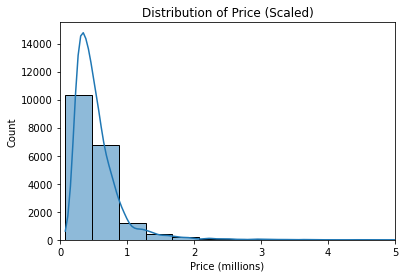

In [67]:
# Import the Seaborn and Matplotlib libraries for data visualization
import seaborn as sns
# sns.histplot(df['price'], kde=True)  # Create a histogram plot for the 'price' column
# plt.title('Distribution of Price')  # Set the title for the plot
# plt.show()  # Display the plot

#scale the price
df['price_scaled'] = df['price'] / 1000000

# Create a histogram plot for the scaled 'price' column
sns.histplot(df['price_scaled'], kde=True, binwidth=0.4)
plt.title('Distribution of Price (Scaled)')
plt.xlabel('Price (millions)')
plt.xlim(0, 5)


plt.show()

Most houses are priced around a half million to a million dollars,
while the most expensive houses imply the order of two million dollars and more

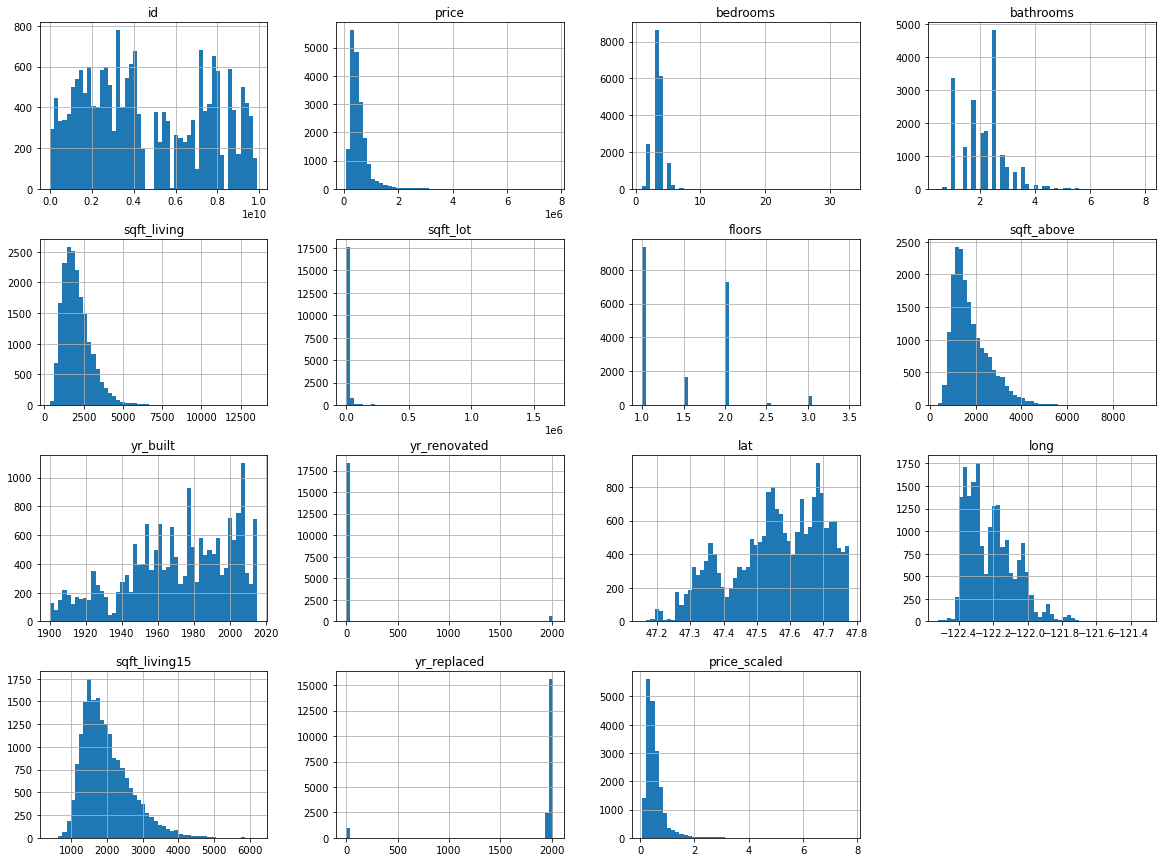

In [68]:
# Set up Matplotlib to display plots inline with the Jupyter Notebook
%matplotlib inline
import matplotlib.pyplot as plt

# Create histograms for all columns in the DataFrame with custom settings
df.hist(bins=50, figsize=(20, 15))
plt.show()  # Display the histograms

<AxesSubplot:xlabel='sqft_above', ylabel='price'>

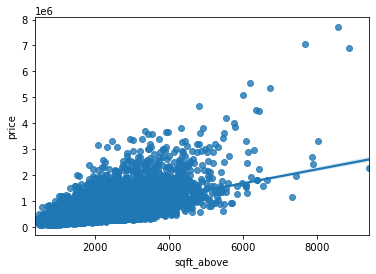

In [69]:
# Create a regression plot using Seaborn to explore the relationship between 'sqft_above' and 'price'
import seaborn as sns
import matplotlib.pyplot as plt
sns.regplot(x='sqft_above', y='price', data=df)

In [70]:
# Replace string values with numeric values in the DataFrame for the 'view' and 'waterfront' columns
# Mapping 'view' categories to numeric values
view_mapping = {'EXCELLENT': 4, 'GOOD': 3, 'AVERAGE': 2, 'FAIR': 1, 'NO': 0}
df.replace(view_mapping, inplace=True)

In [71]:
# Mapping 'waterfront' categories to numeric values
view_mapping = {'YES': 1, 'NO': 0}
df.replace(view_mapping, inplace=True)

In [72]:
# Mapping 'condition' categories to numeric values
view_mapping = {'Average': 3, 'Very Good': 5, 'Good': 4, 'Poor': 1, 'Fair': 2}
df.replace(view_mapping, inplace=True)

In [73]:
# Extract the numeric grade from the 'grade' column and store it in a new 'grade_int' column
df['grade_int'] = df['grade'].str.extract(r'(\d+)').astype(int)

# Drop the 'grade' column from the DataFrame
column_drop = 'grade'
df = df.drop(column_drop, axis=1)

In [74]:
# Preview the dataframe
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,sqft_above,sqft_basement,yr_built,yr_renovated,lat,long,sqft_living15,yr_replaced,price_scaled,grade_int
1,6414100192,2014-12-09,538000.0,3,2.25,2570,7242,2.0,0,0,...,2170,400.0,1951,1991.0,47.7210,-122.319,1690,1991.0,0.538,7
2,5631500400,2015-02-25,180000.0,2,1.00,770,10000,1.0,0,0,...,770,0.0,1933,0.0,47.7379,-122.233,2720,1990.0,0.180,6
3,2487200875,2014-12-09,604000.0,4,3.00,1960,5000,1.0,0,0,...,1050,910.0,1965,0.0,47.5208,-122.393,1360,1982.0,0.604,7
4,1954400510,2015-02-18,510000.0,3,2.00,1680,8080,1.0,0,0,...,1680,0.0,1987,0.0,47.6168,-122.045,1800,2008.0,0.510,8
5,7237550310,2014-05-12,1230000.0,4,4.50,5420,101930,1.0,0,0,...,3890,1530.0,2001,0.0,47.6561,-122.005,4760,2013.0,1.230,11


In [75]:
# Confirm the unique values in the waterfront column. They should be '0' and '1'
df['waterfront'].unique()

array([0, 1])

In [76]:
# Calculate and display the correlation matrix of the DataFrame 'df'
df.corr()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,yr_built,yr_renovated,lat,long,sqft_living15,yr_replaced,price_scaled,grade_int
id,1.000000,-0.019219,0.002728,0.006519,-0.012911,-0.133958,0.017828,-0.004880,0.014068,-0.022813,-0.012369,0.022633,-0.009426,-0.006524,0.018949,-0.002234,-0.001940,-0.019219,0.006593
price,-0.019219,1.000000,0.309329,0.526036,0.703850,0.086395,0.256893,0.271527,0.395255,0.035922,0.608692,0.050753,0.111392,0.305905,0.019495,0.580949,-0.062587,1.000000,0.666696
bedrooms,0.002728,0.309329,1.000000,0.516747,0.578524,0.029797,0.181755,-0.004183,0.083868,0.024352,0.480910,0.156668,0.015972,-0.013258,0.131794,0.393864,-0.076922,0.309329,0.360649
bathrooms,0.006519,0.526036,0.516747,1.000000,0.755730,0.085276,0.505359,0.064609,0.185797,-0.129021,0.687386,0.506215,0.043308,0.024612,0.222399,0.568908,-0.170362,0.526036,0.666311
sqft_living,-0.012911,0.703850,0.578524,0.755730,1.000000,0.172888,0.355893,0.107508,0.285337,-0.059540,0.877730,0.315741,0.045347,0.052498,0.238614,0.755316,-0.105228,0.703850,0.763484
sqft_lot,-0.133958,0.086395,0.029797,0.085276,0.172888,1.000000,-0.008036,0.023128,0.071214,-0.014176,0.183716,0.055218,0.002955,-0.085895,0.229976,0.145875,0.051361,0.086395,0.114249
floors,0.017828,0.256893,0.181755,0.505359,0.355893,-0.008036,1.000000,0.021192,0.027781,-0.266144,0.523979,0.489822,-0.001252,0.050587,0.126026,0.279070,-0.233589,0.256893,0.457470
waterfront,-0.004880,0.271527,-0.004183,0.064609,0.107508,0.023128,0.021192,1.000000,0.407505,0.017118,0.073470,-0.026910,0.079732,-0.013013,-0.040344,0.087340,0.014019,0.271527,0.085743
view,0.014068,0.395255,0.083868,0.185797,0.285337,0.071214,0.027781,0.407505,1.000000,0.046807,0.168069,-0.057609,0.088696,0.009991,-0.078505,0.275601,0.036673,0.395255,0.247601
condition,-0.022813,0.035922,0.024352,-0.129021,-0.059540,-0.014176,-0.266144,0.017118,0.046807,1.000000,-0.158258,-0.364634,-0.055066,-0.019051,-0.106342,-0.094257,0.136166,0.035922,-0.147841


<AxesSubplot:>

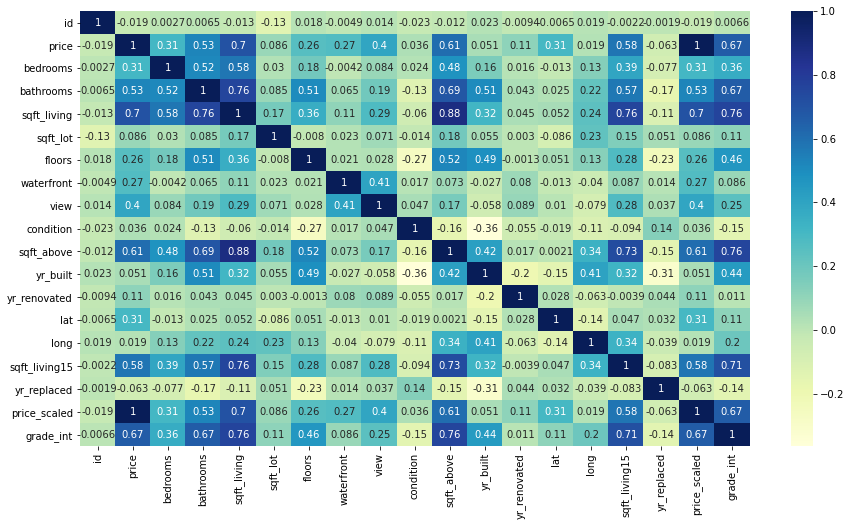

In [77]:
# Create a heatmap to visualize the correlations between different columns in 'df'
plt.figure(figsize=(15, 8))
sns.heatmap(df.corr(), annot=True, cmap='YlGnBu')

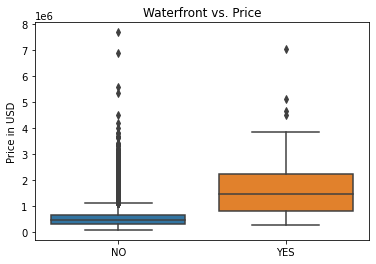

In [78]:
# Create a boxplot to compare 'waterfront' and 'price' with relevant labels and title
sns.boxplot(x=df['waterfront'], y=df['price'])
plt.title("Waterfront vs. Price")
plt.ylabel("Price in USD")
plt.xlabel(None)
plt.xticks(np.arange(2), ('NO', 'YES'))
plt.show()

In [79]:
# Calculate the mean price for houses with and without waterfront, and print the results
waterfront_mean = df[df['waterfront'] == 1]['price'].mean()
nonwaterfront_mean = df[df['waterfront'] == 0]['price'].mean()
print(f"Mean price for houses with waterfront: {round(waterfront_mean, 2)}")
print(f"Mean price for houses with no waterfront: {round(nonwaterfront_mean, 2)}")

Mean price for houses with waterfront: 1692505.86
Mean price for houses with no waterfront: 533912.48


Calculating Mean House Prices for Properties with and without Waterfront

The provided code calculates and prints the mean prices for houses in a dataset, distinguishing between properties with a waterfront view ('waterfront' == 1) and those without a waterfront view ('waterfront' == 0).

**Output:**
- The mean price for houses with a waterfront view is approximately $1,692,505.86.
- The mean price for houses without a waterfront view is approximately $533,912.48.

These calculated mean prices provide valuable insights into the pricing differences between properties with and without waterfront views in the dataset. It indicates that, on average, houses with waterfront views tend to have a significantly higher price compared to those without such views.

## Simple Linear Regression Model

In [80]:
# Import the necessary libraries for statistical modeling
import statsmodels
from statsmodels.formula.api import ols

# Define the dependent variable 'y' and the independent variable 'x'
y = df['price']
x = df['sqft_living']

# Create a linear regression model using Ordinary Least Squares (OLS)
model = ols(formula='price ~ sqft_living', data=df).fit()

In [81]:
# Display a summary of the regression model
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.495
Model:                            OLS   Adj. R-squared:                  0.495
Method:                 Least Squares   F-statistic:                 1.868e+04
Date:                Wed, 25 Oct 2023   Prob (F-statistic):               0.00
Time:                        19:39:07   Log-Likelihood:            -2.6454e+05
No. Observations:               19030   AIC:                         5.291e+05
Df Residuals:                   19028   BIC:                         5.291e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept   -4.743e+04   4721.791    -10.046      

### OLS Regression Results

Here we have the outcome of an Ordinary Least Squares (OLS) linear regression analysis performed on a dataset with 'price' as the dependent variable and 'sqft_living' as the independent variable. These results provide important information about the model's fit, coefficients, significance, and other statistical metrics.

Key Statistics:


- **R-squared (R²):**  R² is approximately 0.495, indicating that about 49.5% of the variation in 'price' can be explained by 'sqft_living.'

- **F-statistic:** A measure of the overall significance of the model. The high value (1.868e+04) suggests that the model is statistically significant.

- **Intercept (Intercept):** The estimated value of 'price' when 'sqft_living' is 0. The coefficient is approximately -47,430.

- **sqft_living (Coefficient for sqft_living):** The estimated change in 'price' for a one-unit increase in 'sqft_living.' In this case, it's approximately 283.1303.

These regression results provide valuable insights into the relationship between 'sqft_living' and 'price,' including the strength and significance of the relationship, potential issues, and diagnostic statistics for assessing the model's quality.


In [82]:
# feature engineering
df['bed_bath_ratio'] = df['bedrooms']/df['bathrooms']

df['sqft_living_squared'] = df['sqft_living'] ** 2

df['living_grade_interaction'] = df['sqft_living'] * df['grade_int']

df['living_condition_interaction'] = df['sqft_living'] * df['condition']

df['living_view_interaction'] = df['sqft_living'] * df['view']

df['location_interaction'] = df['lat'] * df['long']

df['grade_condition_interaction'] = df['grade_int'] * df['condition']


# latest_year = df['date'].max()  # Find the maximum value in the 'yr_replaced' column
df['yr_since_renov'] = 2016 - df['yr_replaced']
# df['yr_since_renov'] = df['yr_replaced'] - df['yr_built']

In [253]:
# negative = df[df['yr_since_renov'] < 0]
# negative


Timestamp('2015-05-27 00:00:00')

In [83]:
# Define a function to extract the month from the 'date' column and add it as a new 'month_of_sale' column
def month_of_sale_feature(data):
    data['month_of_sale'] = pd.DatetimeIndex(data['date']).month
    return data

In [84]:
# Apply the 'month_of_sale_feature' function to the DataFrame 'df' to create the 'month_of_sale' column
df = month_of_sale_feature(df)
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade_int,bed_bath_ratio,sqft_living_squared,living_grade_interaction,living_condition_interaction,living_view_interaction,location_interaction,grade_condition_interaction,yr_since_renov,month_of_sale
1,6414100192,2014-12-09,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,1.333333,6604900,17990,7710,0,-5837.184999,21,25.0,12
2,5631500400,2015-02-25,180000.0,2,1.00,770,10000,1.0,0,0,...,6,2.000000,592900,4620,2310,0,-5835.146731,18,26.0,2
3,2487200875,2014-12-09,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1.333333,3841600,13720,9800,0,-5816.213274,35,34.0,12
4,1954400510,2015-02-18,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1.500000,2822400,13440,5040,0,-5811.392356,24,8.0,2
5,7237550310,2014-05-12,1230000.0,4,4.50,5420,101930,1.0,0,0,...,11,0.888889,29376400,59620,16260,0,-5814.282481,33,3.0,5


In [85]:
# Define a function to categorize months into quarters
def quarter(month):
    if 1 <= month <= 3:
        quarter = 'Q1'
    elif 4 <= month <= 6:
        quarter = 'Q2'
    elif 7 <= month <= 9:
        quarter = 'Q3'
    else:
        quarter = 'Q4'
    return quarter

In [86]:
# Create a new 'quarter_of_sale' column by applying the 'quarter' function to the 'month_of_sale' column
df['quarter_of_sale'] = df['month_of_sale'].apply(quarter)
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,bed_bath_ratio,sqft_living_squared,living_grade_interaction,living_condition_interaction,living_view_interaction,location_interaction,grade_condition_interaction,yr_since_renov,month_of_sale,quarter_of_sale
1,6414100192,2014-12-09,538000.0,3,2.25,2570,7242,2.0,0,0,...,1.333333,6604900,17990,7710,0,-5837.184999,21,25.0,12,Q4
2,5631500400,2015-02-25,180000.0,2,1.00,770,10000,1.0,0,0,...,2.000000,592900,4620,2310,0,-5835.146731,18,26.0,2,Q1
3,2487200875,2014-12-09,604000.0,4,3.00,1960,5000,1.0,0,0,...,1.333333,3841600,13720,9800,0,-5816.213274,35,34.0,12,Q4
4,1954400510,2015-02-18,510000.0,3,2.00,1680,8080,1.0,0,0,...,1.500000,2822400,13440,5040,0,-5811.392356,24,8.0,2,Q1
5,7237550310,2014-05-12,1230000.0,4,4.50,5420,101930,1.0,0,0,...,0.888889,29376400,59620,16260,0,-5814.282481,33,3.0,5,Q2


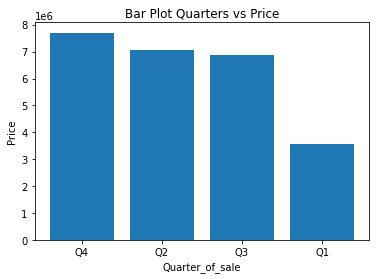

In [87]:
# Extract the categories (quarters) and values (prices) from the DataFrame
categories = df['quarter_of_sale']
values = df['price']

# Create a bar plot to visualize the relationship between quarters and prices
# plt.figure(figsize=(15,7))  # Set the figure size for the plot
# plt.bar(categories, values, color='skyblue')  # Create the initial bar plot

# Sort the data in descending order based on price values
sorted_data = sorted(zip(categories, values), key=lambda x: x[1], reverse=True)
quarters, prices = zip(*sorted_data)

# Create the bar graph with sorted data
plt.bar(quarters, prices)

# Add labels and title to the plot
plt.xlabel('Quarter_of_sale')  # Label for the x-axis
plt.ylabel('Price')  # Label for the y-axis
plt.title('Bar Plot Quarters vs Price')  # Title of the plot

# Display the final bar plot
plt.show()


In [88]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19030 entries, 1 to 21596
Data columns (total 31 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   id                            19030 non-null  int64         
 1   date                          19030 non-null  datetime64[ns]
 2   price                         19030 non-null  float64       
 3   bedrooms                      19030 non-null  int64         
 4   bathrooms                     19030 non-null  float64       
 5   sqft_living                   19030 non-null  int64         
 6   sqft_lot                      19030 non-null  int64         
 7   floors                        19030 non-null  float64       
 8   waterfront                    19030 non-null  int64         
 9   view                          19030 non-null  int64         
 10  condition                     19030 non-null  int64         
 11  sqft_above                  

In [89]:
columns_to_drop = ['id', 'id', 'sqft_lot', 'yr_renovated']

df.drop(columns=columns_to_drop, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19030 entries, 1 to 21596
Data columns (total 28 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   date                          19030 non-null  datetime64[ns]
 1   price                         19030 non-null  float64       
 2   bedrooms                      19030 non-null  int64         
 3   bathrooms                     19030 non-null  float64       
 4   sqft_living                   19030 non-null  int64         
 5   floors                        19030 non-null  float64       
 6   waterfront                    19030 non-null  int64         
 7   view                          19030 non-null  int64         
 8   condition                     19030 non-null  int64         
 9   sqft_above                    19030 non-null  int64         
 10  sqft_basement                 19030 non-null  object        
 11  yr_built                    

In [90]:
df.drop(columns='sqft_living_squared', inplace=True)

In [93]:
df.corr()

,price,bedrooms,bathrooms,sqft_living,floors,waterfront,view,condition,sqft_above,yr_built,...,price_scaled,grade_int,bed_bath_ratio,living_grade_interaction,living_condition_interaction,living_view_interaction,location_interaction,grade_condition_interaction,yr_since_renov,month_of_sale
price,1.000000,0.309329,0.526036,0.703850,0.256893,0.271527,0.395255,0.035922,0.608692,0.050753,...,1.000000,0.666696,-0.248676,0.758129,0.677809,0.514072,-0.265200,0.490585,0.062587,-0.008294
bedrooms,0.309329,1.000000,0.516747,0.578524,0.181755,-0.004183,0.083868,0.024352,0.480910,0.156668,...,0.309329,0.360649,0.210247,0.507230,0.549134,0.142410,0.058142,0.267228,0.076922,-0.001241
bathrooms,0.526036,0.516747,1.000000,0.755730,0.505359,0.064609,0.185797,-0.129021,0.687386,0.506215,...,0.526036,0.666311,-0.651042,0.738833,0.650174,0.278380,0.056301,0.341330,0.170362,0.009107
sqft_living,0.703850,0.578524,0.755730,1.000000,0.355893,0.107508,0.285337,-0.059540,0.877730,0.315741,...,0.703850,0.763484,-0.322103,0.973768,0.903862,0.418911,0.037232,0.466985,0.105228,0.013389
floors,0.256893,0.181755,0.505359,0.355893,1.000000,0.021192,0.027781,-0.266144,0.523979,0.489822,...,0.256893,0.457470,-0.374725,0.373694,0.224763,0.066381,-0.000741,0.080772,0.233589,0.012816
waterfront,0.271527,-0.004183,0.064609,0.107508,0.021192,1.000000,0.407505,0.017118,0.073470,-0.026910,...,0.271527,0.085743,-0.048222,0.116937,0.108906,0.391236,-0.002550,0.075926,-0.014019,0.009211
view,0.395255,0.083868,0.185797,0.285337,0.027781,0.407505,1.000000,0.046807,0.168069,-0.057609,...,0.395255,0.247601,-0.103624,0.299424,0.295032,0.904774,-0.036483,0.216423,-0.036673,-0.005572
condition,0.035922,0.024352,-0.129021,-0.059540,-0.266144,0.017118,0.046807,1.000000,-0.158258,-0.364634,...,0.035922,-0.147841,0.135305,-0.085109,0.337047,0.033203,-0.020482,0.733253,-0.136166,0.020945
sqft_above,0.608692,0.480910,0.687386,0.877730,0.523979,0.073470,0.168069,-0.158258,1.000000,0.420531,...,0.608692,0.757520,-0.316259,0.882833,0.735760,0.280980,0.118366,0.372989,0.150918,0.011901
yr_built,0.050753,0.156668,0.506215,0.315741,0.489822,-0.026910,-0.057609,-0.364634,0.420531,1.000000,...,0.050753,0.444908,-0.435885,0.332872,0.132531,-0.008714,0.274795,-0.017535,0.311247,-0.004039


## Multiple Linear Regression Model

In the following cell the additional independent variables used, were only those with the highest correlation to the price.

In [98]:
# Create a multiple linear regression model using Ordinary Least Squares (OLS)
model = ols(formula='price ~ sqft_living + living_grade_interaction + living_condition_interaction + grade_int + sqft_above + sqft_living15 + bathrooms + living_view_interaction ', data=df).fit()

# Display a summary of the regression model
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.648
Model:                            OLS   Adj. R-squared:                  0.648
Method:                 Least Squares   F-statistic:                     4378.
Date:                Wed, 25 Oct 2023   Prob (F-statistic):               0.00
Time:                        19:56:32   Log-Likelihood:            -2.6111e+05
No. Observations:               19030   AIC:                         5.222e+05
Df Residuals:                   19021   BIC:                         5.223e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                      2.88e+05   2.23e+04     12.940      0.000    2.44e+05    3.32e+05
sqft_living                   -385.1957     11.365    -33.894      0.000    -407.471    -362.920
living_grade_interaction        50.4533      1.043     48.350      0.000      48.408      52.499
living_condition_interaction    32.4886      1.181     27.502      0.000      30.173      34.804
grade_int                    -4698.7892   3283.428     -1.431      0.152   -1.11e+04    1737.021
sqft_above                     -35.5860      4.487     -7.930      0.000     -44.382     -26.790
sqft_living15                   20.0352      3.821      5.243      0.000      12.546      27.525
bathrooms                      1.08e+04   3333.510      3.240      0.001    4265.468    1.73e+04
living_view_interaction         25.0778      0.732     34.266      0.000      23.643      26.512
==============================================================================
Omnibus:                     8820.003   Durbin-Watson:                   1.998
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           303915.831
Skew:                           1.585   Prob(JB):                         0.00
Kurtosis:                      22.319   Cond. No.                     3.02e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.02e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### OLS Regression Results

The presented output displays the results of an Ordinary Least Squares (OLS) linear regression analysis. In this regression model, 'price' is considered the dependent variable, and several independent variables are included to predict the housing prices. Here's a breakdown of the key statistics and coefficients:

Key Statistics:

- **R-squared (R²):** R-squared value is approximately 0.719, indicating that approximately 71.9% of the variation in housing prices can be explained by the included independent variables.

- **F-statistic:** The F-statistic measures the overall significance of the model. The high F-statistic value (6096) suggests that the model is statistically significant.

  - 'sqft_living' has a coefficient of approximately -302.6978, indicating that a one-unit increase in square footage of living space corresponds to a decrease in price.
  - 'living_view_interaction' and 'living_grade_interaction' also have coefficients, suggesting their impact on the price.
  - Similar interpretations apply to other coefficients such as 'yr_built,' 'location_interaction,' 'bed_bath_ratio,' and 'month_of_sale.'

These regression results provide insights into the relationships between various independent variables and housing prices, as well as the overall model fit and diagnostic statistics.


## Testing the models predictive performance

In [ ]:
from sklearn.model_selection import train_test_split

X = df.drop(['price', 'date', 'quarter_of_sale', 'sqft_basement'], axis=1)
y = df['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("number of test samples :", X_test.shape[0])
print("number of training samples:",X_train.shape[0])

number of test samples : 3806
number of training samples: 15224


In [ ]:
# Import necessary libraries and modules for data preprocessing, model creation, and evaluation
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

# Split the data into features (X) and target (y), while excluding specific columns
X = df.drop(['price', 'date', 'quarter_of_sale', 'sqft_basement'], axis=1)
y = df['price']

# Split the data into training and test sets using train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Display the number of test and training samples
print("Number of test samples:", X_test.shape[0])
print("Number of training samples:", X_train.shape[0])

# Create a data preprocessing pipeline that includes data scaling and a linear regression model
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Scaling the data
    ('regressor', LinearRegression())  # Linear Regression model
])

# Fit the pipeline on the training data, which includes scaling the features
pipeline.fit(X_train, y_train)

# Make predictions on the test data
y_pred = pipeline.predict(X_test)

# Calculate the Root Mean Squared Error (RMSE) as a measure of the model's prediction accuracy
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Root Mean Squared Error (RMSE): {rmse}")

Root Mean Squared Error (RMSE): 186325.31294791534


In [ ]:
# Create a separate Linear Regression model, fit it on the test data, and calculate the R-squared score
reg = LinearRegression()
reg.fit(X_test, y_test)
r2_score = reg.score(X_test, y_test)

# Print the R-squared score to evaluate the model's performance on the test data
print(f"R-squared Score: {r2_score}")


R-squared Score: 0.7377125832264463


### Evaluating the Model's Performance

In this code, a linear regression model has been trained, and its performance on the test data is assessed using two key metrics: Root Mean Squared Error (RMSE) and R-squared (R²) score.

#### Root Mean Squared Error (RMSE)

RMSE is a measure of the model's prediction accuracy. In this analysis, the RMSE is approximately 186,325.31. This value represents the square root of the average squared differences between the predicted housing prices and the actual prices in the test data. A lower RMSE indicates that the model's predictions are closer to the actual values, signifying better prediction accuracy.

#### R-squared Score (R²)

R-squared (R²) measures the proportion of variance in the dependent variable ('price') that is explained by the independent variables used in the model. The R² score is approximately 0.738, which means that roughly 73.8% of the variation in housing prices can be explained by the features included in the model. A higher R² score indicates a better fit, suggesting that the model is successful in explaining a significant portion of the variance in housing prices.


## Training Another Model

In [ ]:
# Import the RandomForestRegressor from sklearn's ensemble module
from sklearn.ensemble import RandomForestRegressor

# Create a RandomForestRegressor model
forest = RandomForestRegressor()

# Fit the model using the training data
forest.fit(X_train, y_train)

RandomForestRegressor()

In [ ]:
# Evaluate the model's performance on the test data and print the R-squared score
forest.score(X_test, y_test)

0.8760968986909982

The RandomForest Regressor does a better job at predicting than the linear regression model

In [ ]:
# Import GridSearchCV for hyperparameter tuning
from sklearn.model_selection import GridSearchCV

# Create another RandomForestRegressor model
forest = RandomForestRegressor()

# Define a parameter grid for hyperparameter tuning
param_grid = {
    "n_estimators": [100, 100, 100],  # Number of decision trees in the forest
    "min_samples_split": [2, 4],  # Minimum samples required to split an internal node
    "max_depth": [None, 4, 8]  # Maximum depth of the decision trees
}
s = 3  # Number of cross-validation folds

# Perform a grid search to find the best hyperparameters based on neg_mean_squared_error scoring
grid_search = GridSearchCV(forest, param_grid, cv=s, scoring="neg_mean_squared_error", return_train_score=True)

# Fit the grid search on the training data to identify the best estimator (model)
grid_search.fit(X_train, y_train)


GridSearchCV(cv=3, estimator=RandomForestRegressor(),
             param_grid={'max_depth': [None, 4, 8], 'min_samples_split': [2, 4],
                         'n_estimators': [100, 100, 100]},
             return_train_score=True, scoring='neg_mean_squared_error')

In [ ]:
# Retrieve the best forest model from the grid search
best_forest = grid_search.best_estimator_

In [ ]:
# Evaluate the best forest model's performance on the test data and print the R-squared score
best_forest.score(X_test, y_test)

0.8757092873397977

### Random Forest Regression Results

In the code snippet provided, two Random Forest Regression models were trained and evaluated for predicting housing prices.

First Random Forest Model (Unoptimized)

The first Random Forest model was created without hyperparameter optimization. Here's a breakdown of the results:

- The model's performance was evaluated on the test data, and the R-squared score was calculated. The R-squared score is approximately 0.8761, which suggests that the model can explain around 87.61% of the variance in housing prices in the test dataset. This indicates a strong predictive capability.

Hyperparameter-Tuned Random Forest Model

The second Random Forest model was optimized using hyperparameter tuning. The process involved a grid search to find the best combination of hyperparameters.

- The R-squared score for the optimized model is approximately 0.8757. While it is slightly lower than the unoptimized model, it is still quite high, indicating strong predictive performance.

In summary, both Random Forest models demonstrate strong predictive capabilities, with R-squared scores of around 0.8761 for the unoptimized model and 0.8757 for the optimized model. These results suggest that Random Forest Regression is a suitable choice for predicting housing prices in this dataset, and the optimized model achieved comparable performance to the unoptimized model. Further fine-tuning or additional evaluation metrics can be explored to fine-tune the model if necessary.


## Conclusions

In conclusion, our predictive model accounts for approximately 72% of the variance in house prices which signifies a strong predictive power. The factors considered include, square footage, location, view and waterfront, which have a substantial impact on property values. It's important to keep in mind, however, that real estate is influenced by many more dynamic variables thus achieving 100% accuracy in predicting house prices is challenging. Our model’s performance is encouraging and can aid in estimating property values in King County thus providing a reliable method for both buyers and sellers. 
Although this model is reliable, it should be used in conjunction with other information for more precise pricing decisions.